In [74]:
#@title Insatlling PyTorch

!pip install torch
!pip install torchvision

In [75]:
#@title Import dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [83]:
#@title Define hyperparameters

input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = [100, 100] # number of neurons at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 20 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-3 # size of step

In [84]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)
test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
print("Size of the train dataset:",tuple(train_data.data.shape))
print("Size of the test dataset:",tuple(test_data.data.shape))

Size of the train dataset: (60000, 28, 28)
Size of the test dataset: (10000, 28, 28)


In [85]:
#@title Loading the data

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

Image size: (28, 28)
Label of this image: 3


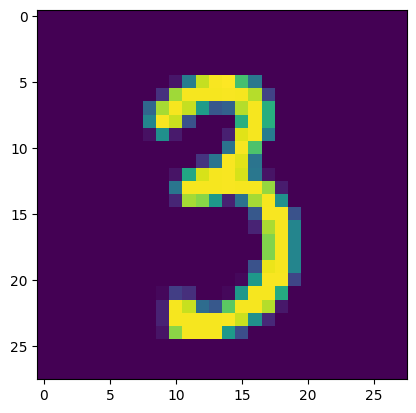

In [86]:
#@title Show the data

images = train_data.data
labels = train_data.targets
image_inx = 98
image = images[image_inx]
label = labels[image_inx]
print("Image size:",tuple(image.shape))
print("Label of this image:",label.numpy())
plt.imshow(image.numpy().squeeze())

In [87]:
#@title Define model class

class FCNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FCNN, self).__init__()

        layer_sizes = [input_size] + hidden_sizes + [output_size]
        layers = []

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.ReLU())  # Using ReLU activation function

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [88]:
#@title Build the model

model = FCNN(input_size, hidden_size, num_classes)
if torch.cuda.is_available(): # GPU
  model.cuda()
  print("Using GPU (CUDA)")
else:
  print("Using CPU")


Using CPU


In [89]:
#@title Define loss function & optimizer

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Epoch [1/20], Step [100/600], Loss: 0.5327
Epoch [1/20], Step [200/600], Loss: 0.3082
Epoch [1/20], Step [300/600], Loss: 0.1671
Epoch [1/20], Step [400/600], Loss: 0.2588
Epoch [1/20], Step [500/600], Loss: 0.1363
Epoch [1/20], Step [600/600], Loss: 0.1338
Epoch [1/20], Train Loss: 0.3852, Train Acc: 89.44%, Val Loss: 0.1856, Val Acc: 94.35%
Epoch [2/20], Step [100/600], Loss: 0.1348
Epoch [2/20], Step [200/600], Loss: 0.1407
Epoch [2/20], Step [300/600], Loss: 0.2035
Epoch [2/20], Step [400/600], Loss: 0.2065
Epoch [2/20], Step [500/600], Loss: 0.1052
Epoch [2/20], Step [600/600], Loss: 0.1727
Epoch [2/20], Train Loss: 0.1623, Train Acc: 95.15%, Val Loss: 0.1373, Val Acc: 96.03%
Epoch [3/20], Step [100/600], Loss: 0.0969
Epoch [3/20], Step [200/600], Loss: 0.0836
Epoch [3/20], Step [300/600], Loss: 0.0412
Epoch [3/20], Step [400/600], Loss: 0.1952
Epoch [3/20], Step [500/600], Loss: 0.0476
Epoch [3/20], Step [600/600], Loss: 0.0893
Epoch [3/20], Train Loss: 0.1124, Train Acc: 96.65%,

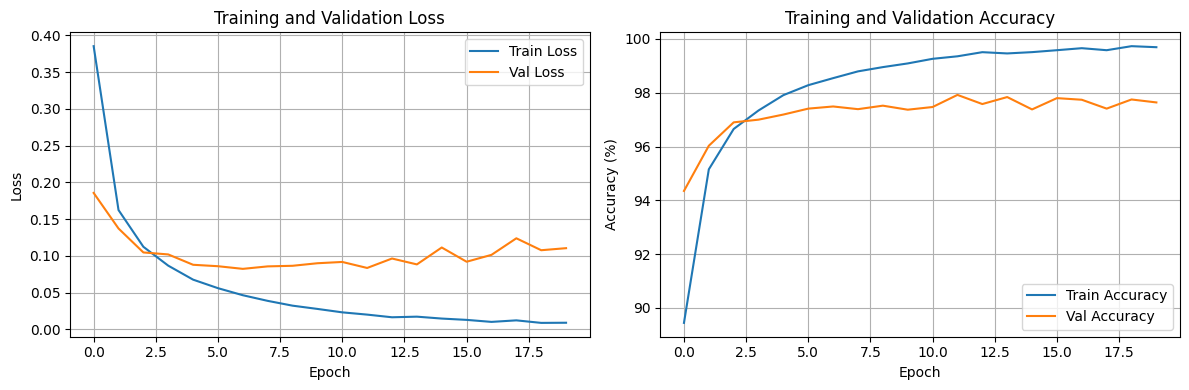

Final Test Accuracy: 97.64%


In [90]:
#@title Training the model
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        # Move data to the device
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28)).cuda()
            labels = Variable(labels).cuda()
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i+1) % batch_size == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                     %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

    # Calculate the average loss and accuracy of the training set
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = Variable(images.view(-1, 28*28)).cuda()
                labels = Variable(labels).cuda()
            else:
                images = Variable(images.view(-1, 28*28))
                labels = Variable(labels)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the average loss and accuracy of the validation set
    val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

# Plot the loss curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final model performance
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        if torch.cuda.is_available():
            images = images.view(-1, 28*28).cuda()
            labels = labels.cuda()
        else:
            images = images.view(-1, 28*28)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Test Accuracy: {100 * correct / total:.2f}%')

In [92]:
#@title Save the model

torch.save(model.state_dict(), '/content/model.pth')

Label of the image: 7
The prediction: [7]


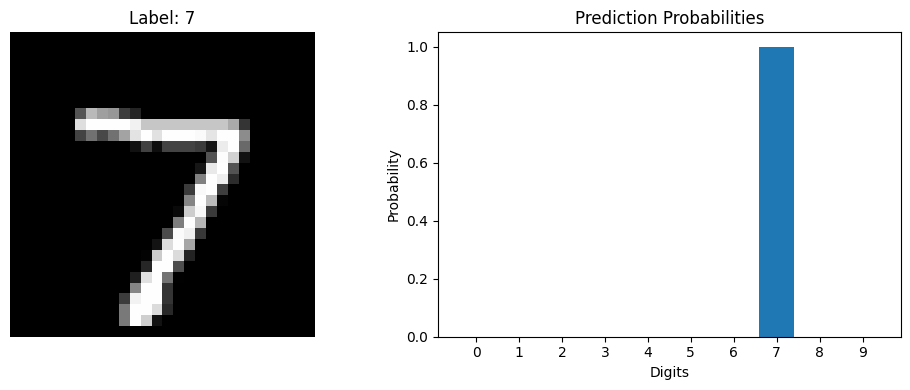

In [97]:
#@title Test some examples in MNIST (Correct prediction: 7)

image_inx = 0
images = test_data.data
labels = test_data.targets
image = images[image_inx].to(torch.float32)
label = labels[image_inx]
model.cpu()
output = model(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",label.numpy())
print("The prediction:",prediction.numpy())

# Plot the probability graph
probabilities = torch.nn.functional.softmax(output, dim=1)
prob_numpy = probabilities.detach().numpy().squeeze()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.title(f'Label: {label.item()}')
plt.axis('off')

plt.subplot(1, 2, 2)
bars = plt.bar(range(10), prob_numpy)
plt.xlabel('Digits')
plt.ylabel('Probability')
plt.title('Prediction Probabilities')
plt.xticks(range(10))

plt.tight_layout()
plt.show()

Label of the image: 9
The prediction: [9]


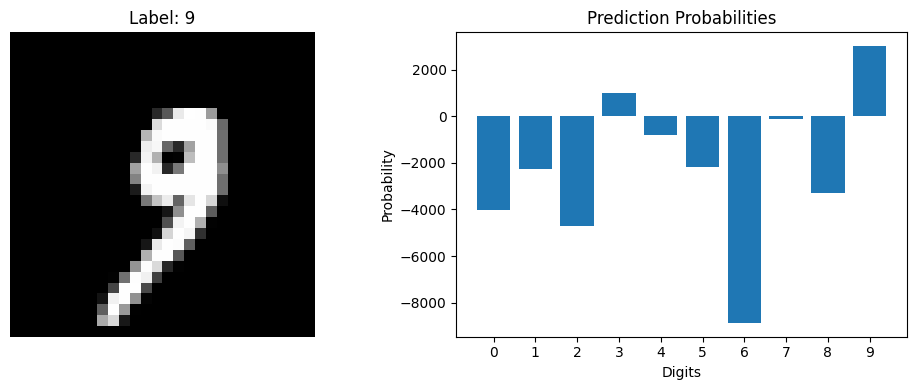

In [101]:
#@title Test some examples in MNIST (Correct prediction: 9)

image_inx = 1000
images = test_data.data
labels = test_data.targets
image = images[image_inx].to(torch.float32)
label = labels[image_inx]
model.cpu()
output = model(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",label.numpy())
print("The prediction:",prediction.numpy())

# Plot the probability graph
probabilities = torch.nn.functional.softmax(output, dim=1)
prob_numpy = probabilities.detach().numpy().squeeze()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.title(f'Label: {label.item()}')
plt.axis('off')

plt.subplot(1, 2, 2)
bars = plt.bar(range(10), prob_numpy)
plt.xlabel('Digits')
plt.ylabel('Probability')
plt.title('Prediction Probabilities')
plt.xticks(range(10))

plt.tight_layout()
plt.show()

Label of the image: 6
The prediction: [0]


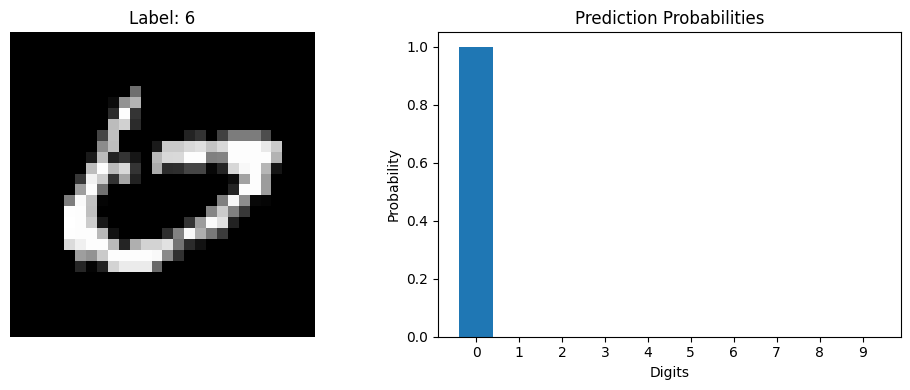

In [99]:
#@title Test some examples in MNIST (Wrong prediction: 6 or 0?)

image_inx = 445
images = test_data.data
labels = test_data.targets
image = images[image_inx].to(torch.float32)
label = labels[image_inx]
model.cpu()
output = model(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",label.numpy())
print("The prediction:",prediction.numpy())

# Plot the probability graph
probabilities = torch.nn.functional.softmax(output, dim=1)
prob_numpy = probabilities.detach().numpy().squeeze()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.title(f'Label: {label.item()}')
plt.axis('off')

plt.subplot(1, 2, 2)
bars = plt.bar(range(10), prob_numpy)
plt.xlabel('Digits')
plt.ylabel('Probability')
plt.title('Prediction Probabilities')
plt.xticks(range(10))

plt.tight_layout()
plt.show()

Label of the image: 5
The prediction: [6]


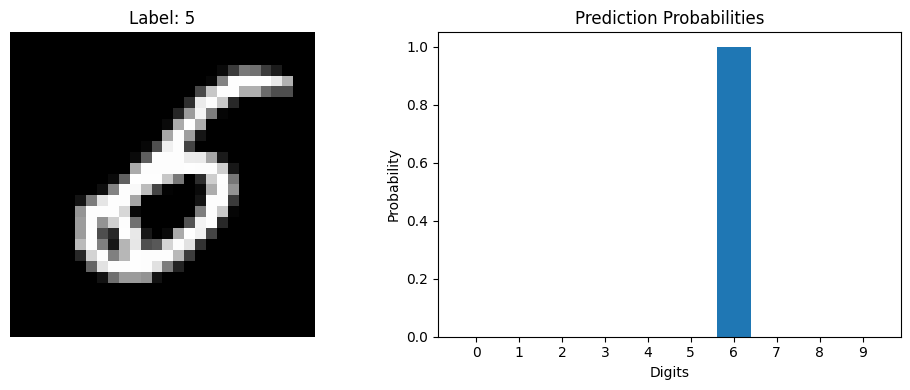

In [100]:
#@title Test some examples in MNIST (Wrong prediction: 5 or 6)

image_inx = 9729
images = test_data.data
labels = test_data.targets
image = images[image_inx].to(torch.float32)
label = labels[image_inx]
model.cpu()
output = model(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",label.numpy())
print("The prediction:",prediction.numpy())

# Plot the probability graph
probabilities = torch.nn.functional.softmax(output, dim=1)
prob_numpy = probabilities.detach().numpy().squeeze()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.title(f'Label: {label.item()}')
plt.axis('off')

plt.subplot(1, 2, 2)
bars = plt.bar(range(10), prob_numpy)
plt.xlabel('Digits')
plt.ylabel('Probability')
plt.title('Prediction Probabilities')
plt.xticks(range(10))

plt.tight_layout()
plt.show()